In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!unzip -o garbage-image-dataset.zip

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

In [ ]:
dataset_path = 'TrashType_Image_Dataset'
class_labels = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
num_classes = len(class_labels)
image_size = (227, 227)
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
base_model = VGG16(include_top=False, input_shape=(227, 227, 3), weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# phase 1 Training
history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=15,
    callbacks=[early_stopping]
)

# phase 2: unfreeze last few VGG16 layers for fine tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:  # freeze all but last 4 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# fine tuning
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# combine histories
def combine_history(h1, h2):
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history[key]
    return combined

full_history = combine_history(history1, history2)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1538s 24s/step - accuracy: 0.4545 - loss: 1.8047 - val_accuracy: 0.3917 - val_loss: 3.9883
Epoch 2/20
 1/63 ━━━━━━━━━━━━━━━━━━━━ 19:11 19s/step - accuracy: 0.5938 - loss: 0.8827

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.5938 - loss: 0.8827 - val_accuracy: 0.3938 - val_loss: 3.8672
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1547s 24s/step - accuracy: 0.6197 - loss: 1.0755 - val_accuracy: 0.6375 - val_loss: 1.1458
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 310s 5s/step - accuracy: 0.4688 - loss: 1.0004 - val_accuracy: 0.6417 - val_loss: 1.1177
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1516s 24s/step - accuracy: 0.6606 - loss: 0.9014 - val_accuracy: 0.6687 - val_loss: 0.9334
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.6562 - loss: 0.8461 - val_accuracy: 0.6750 - val_loss: 0.9059
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1524s 24s/step - accuracy: 0.6796 - loss: 0.8445 - val_accuracy: 0.7042 - val_loss: 0.8119
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.7812 - loss: 0.6128 - val_accuracy: 0.7000 - val_loss: 0.8124
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1582s 25s/step - accuracy: 0.7217 - loss: 0.7835 - val_accuracy: 0.7437 - val_

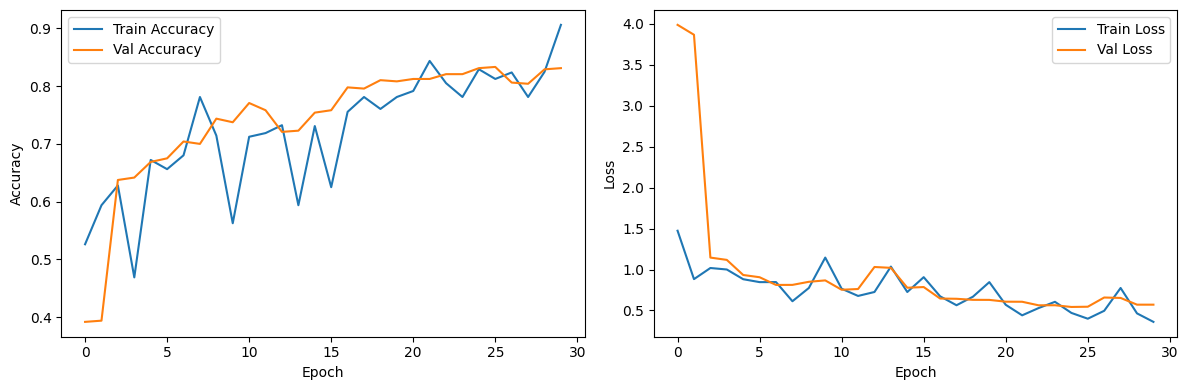

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(full_history['accuracy'], label='Train Accuracy')
plt.plot(full_history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# evaluate final accuracy
val_loss, val_acc = model.evaluate(validation_generator)
print(f"\n✅ Final Validation Accuracy: {val_acc * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 298s 19s/step - accuracy: 0.8727 - loss: 0.3630

✅ Final Validation Accuracy: 81.11%


16/16 ━━━━━━━━━━━━━━━━━━━━ 299s 19s/step


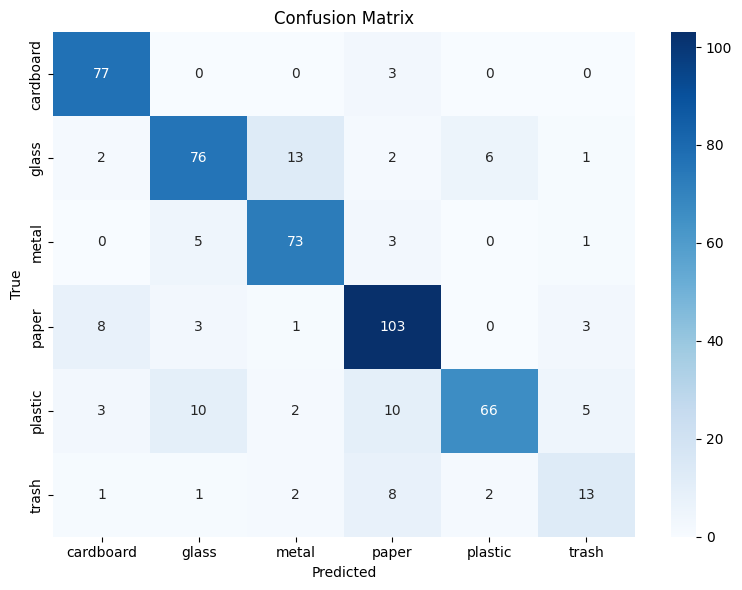

In [ ]:
# confusion Matrix
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
model.save('trash_classification_model.keras')
files.download('trash_classification_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>